### 1. Implementación de un Multilayer Perceptron

• Conjunto de datos MNIST

• Tarea compleja

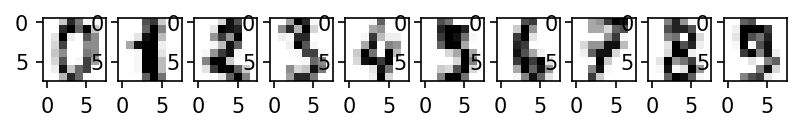

In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
digits = load_digits()
fig, ax = plt.subplots(1, 10,dpi=150)
for i in range(10):
    ax[i].imshow(digits.images[i], cmap='Greys')
# plt.savefig('figures/05_12.png', dpi=300)
plt.show()

In [2]:
X = digits.data
y = digits.target
print('Etiquetas de Clase:', np.unique(y))

Etiquetas de Clase: [0 1 2 3 4 5 6 7 8 9]


In [3]:
print('Datos por Clase:', np.bincount(y))

Datos por Clase: [178 182 177 183 181 182 181 179 174 180]


In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.3,random_state= 271828, stratify= y)

In [5]:
print('Datos por Clase:', np.bincount(y_train))

Datos por Clase: [124 127 124 128 127 127 127 125 122 126]


In [6]:
print('Datos por Clase:', np.bincount(y_test))

Datos por Clase: [54 55 53 55 54 55 54 54 52 54]


Observemos el subespacio de entrada

In [7]:
x_train.shape

(1257, 64)

In [8]:
np.min(x_train)

0.0

In [9]:
np.max(x_train)

16.0

In [10]:
x_train = x_train.astype('float32') / 16
x_test = x_test.astype('float32') / 16

In [11]:
import sys
class NeuralNetMLP(object):
    """ Clasificador MLP de una sola Capa Oculta.
    Parameters
    ------------
    n_hidden : int (default: 30)
    Número de unidades ocultas.
    l2 : float (default: 0.)
    Valor lambda para Regularización L2.
    Si l2=0 (default), no hay Regularización.
    epochs : int (default: 100)
    Número de pasadas sobre el conjunto de entrenamiento.
    eta : float (default: 0.001)
    Tasa de aprendizaje.
    shuffle : bool (default: True)
    Si es True, mezcla los datos de entrenamiento cada época.
    minibatch_size : int (default: 1)
    Número de muestras de entrenamiento por minibatch.
    seed : int (default: None)
    Semilla aleatoria para inicializar pesos y barajar (mezclar).
    Attributes
    -----------
    eval_ : dict
    Diccionario que almacena valord e la pérdida, la exactitud del entrenamiento
    y la exactitud del test para cada época de entrenamiento.
    """
    def __init__(self, n_hidden=30, l2=0.,epochs=100, eta=0.001,shuffle=True, minibatch_size=1, seed=None):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
    
    def _onehot(self, y, n_classes):
        """Codificar etiquetas en representación one-hot.
        Parameters
        ------------
        y : array, shape = [n_samples]
        Vector de etiquetas.
        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)
        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """Calcular la función de activación Sigmoide"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def _forward(self, X):
        """Calcular el paso de propagación hacia adelante"""
        #paso 1: entrada de la capa oculta
        #[n_samples,n_features+1] * [n_features+1,n_hidden] ->[n_samples,n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h
        #paso 2: activación de la capa oculta
        a_h = self._sigmoid(z_h)
        #paso 3: entrada de la capa de salida
        #[n_samples,n_hidden+1] * [n_hidden+1,n_classlabels] ->[n_samples,n_classlabels]
        z_out = np.dot(a_h, self.w_out) + self.b_out
        #paso 4: activación de la capa de salida
        a_out = self._sigmoid(z_out)
        return z_h, a_h, z_out, a_out
    
    def _compute_cost(self, y_enc, output):
        """Calcular la función de pérdida. En este caso,
        se utiliza la Función de Costo Logístico.
        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels)
        Etiquetas de clase codificadas one-hot.
        output : array, shape = [n_samples, n_output_units]
        Activación de la capa de salida (propagación hacia adelante)
        Returns
        ---------
        cost : float
        Valor de la pérdida.
        """
        L2_term = (self.l2 *(np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.)))
        term1 = -y_enc * (np.log(output))
        term2 = -(1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        #Si está aplicando esta función de pérdida a otros conjuntos de datos␣donde los valores
        #de activación pueden volverse más extremos (más cerca de cero o 1),␣es posible
        #que se encuentre con "ZeroDivisionError" debido a inestabilidades␣numéricas en Python y NumPy
        #para la implementación actual. Es decir, el código intenta evaluar␣log(0),
        #que no está definido. Para solucionar este problema, se puede agregar␣una pequeña
        #constante a los valores de activación que se pasan a la función de␣pérdida.
        #
        #Por ejemplo:
        #
        #term1 = -y_enc * (np.log(output + 1e-5))
        #term2 = (1. - y_enc) * np.log(1. - output + 1e-5)
        return cost
    
    def predict(self, X):
        """Predecir etiquetas de clases.
        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
        Matriz de características.
        Returns:
        ----------
        y_pred : array, shape = [n_samples]
        Etiquetas de clase predichas.
        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred
    
    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Aprendizaje de los pesos a partir de datos de entrenamiento.
        Parameters
        -----------
        X_train : array, shape = [n_samples, n_features]
        Matriz de entrada con características originales.
        y_train : array, shape = [n_samples]
        Etiquetas de clase.
        X_valid : array, shape = [n_samples, n_features]
        Matriz de características para validación durante el entrenamiento
        y_valid : array, shape = [n_samples]
        Etiquetas de clase para validación durante el entrenamiento
        Returns:
        ----------
        self
        """
        n_output = np.unique(y_train).shape[0]
        n_features = X_train.shape[1]
        #############################
        #Inicialización de los Pesos
        #############################
        #pesos para capa entrada-oculta
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,size=(n_features, self.n_hidden))
        #pesos para capa oculta-salida
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,size=(self.n_hidden,n_output))
        epoch_strlen = len(str(self.epochs))
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        y_train_enc = self._onehot(y_train, n_output)
        for i in range(self.epochs):
        #iterar sobre minibatches
            indices = np.arange(X_train.shape[0])
            if self.shuffle:
                self.random.shuffle(indices)
            for start_idx in range(0,indices.shape[0] - self.minibatch_size+1,self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                #propagación hacia adelante
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])
                ##################################
                #Backpropagation: En este caso,
                #para Función de Costo Logístico.
                ##################################
                #[n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]
                #[n_samples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)
                #[n_samples, n_classlabels] dot [n_classlabels, n_hidden]
                #-> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T)*sigmoid_derivative_h)
                #[n_features, n_samples] dot [n_samples, n_hidden]
                #-> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)
                #[n_hidden, n_samples] dot [n_samples, n_classlabels]
                #-> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)
                # Regularización y actualización de pesos
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # coeficiente de sesgo no está regularizado
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h
                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out
            #############
            #Evaluación
            #############
            z_h, a_h, z_out, a_out = self._forward(X_train)
            cost = self._compute_cost(y_enc=y_train_enc,output=a_out)
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            train_acc = ((np.sum(y_train == y_train_pred)).astype(float) /X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(float) /X_valid.shape[0])
            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
'| Train/Valid Acc.: %.2f%%/%.2f%% ' %
(epoch_strlen, i+1, self.epochs, cost,
train_acc*100, valid_acc*100))
            sys.stderr.flush()
            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
        return self

In [12]:
MLP = NeuralNetMLP(n_hidden=100,l2=0.01,epochs=20,eta=0.0005,minibatch_size=64,shuffle=True,seed=10)
MLP.fit(X_train=x_train, y_train=y_train,X_valid=x_test, y_valid=y_test)

20/20 | Cost: 1400.45 | Train/Valid Acc.: 78.68%/78.52% 

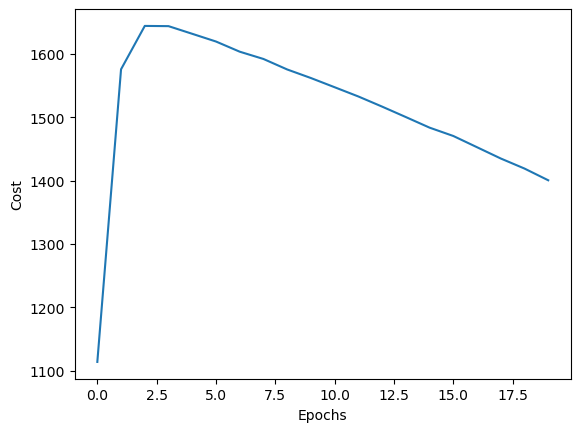

In [13]:
import matplotlib.pyplot as plt

plt.plot(range(MLP.epochs), MLP.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

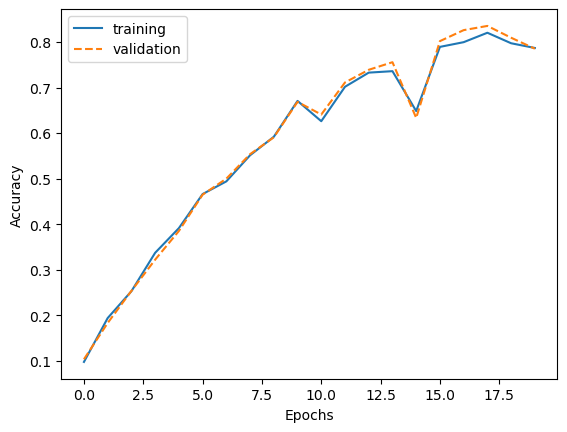

In [14]:
plt.plot(range(MLP.epochs), MLP.eval_['train_acc'], label='training')
plt.plot(range(MLP.epochs), MLP.eval_['valid_acc'], label='validation',linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [15]:
y_test_pred = MLP.predict(x_test)
acc = (np.sum(y_test == y_test_pred).astype(float) / x_test.shape[0])
print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 78.52%
